# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import random
from tqdm import tqdm
import cv2 as cv
import PIL
from PIL import Image
!pip install plotly
import plotly.express as px
from IPython import display

In [3]:
%tensorflow_version 1.x
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2

from PIL import Image
import os
import time
import re
import shutil
import pickle

TensorFlow 1.x selected.


## Download a Pre-Trained Model

In [4]:
# @Download a Pre-Trained Model

%cd /content
!gdown -O "cryptopunks_3_run.zip" --id 1Vwj50ftdTLkoyps4KT-8-ihCLHuTOXK1
!mkdir -p checkpoint
!unzip "cryptopunks_3_run.zip" -d checkpoint

run_name = 'cryptopunks_3_run'

/content
Downloading...
From: https://drive.google.com/uc?id=1Vwj50ftdTLkoyps4KT-8-ihCLHuTOXK1
To: /content/cryptopunks_3_run.zip
100% 463M/463M [00:03<00:00, 128MB/s]
Archive:  cryptopunks_3_run.zip
replace checkpoint/cryptopunks_3_run/encoder.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: checkpoint/cryptopunks_3_run/encoder.json  
replace checkpoint/cryptopunks_3_run/checkpoint? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: checkpoint/cryptopunks_3_run/checkpoint  
replace checkpoint/cryptopunks_3_run/counter? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: checkpoint/cryptopunks_3_run/counter  
replace checkpoint/cryptopunks_3_run/hparams.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: checkpoint/cryptopunks_3_run/hparams.json  
replace checkpoint/cryptopunks_3_run/model-3000.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: checkpoint/cryptopunks_3_run/model-3000.index  
  inflating: checkpoint/cryptopunks_3_run/vocab.bpe  
  inflating:

# Generate New Punks

Here we'll generate your punks sprites images with the model we imported and save them to Google Drive.

There are a few settings you can change for this cell:

- output_folder - This is the folder that sprites will be saved to in your Google Drive
- generate_count - This is how many sprites will be generated when you run this cell
- temperature - This controls how "crazy" the output is. A high number will lead weird looking cryptpunk, but might be interesting. Too low will be boring. Play with this number.




In [5]:
# @Generation settings

output_folder = 'output_punks' #@param {type:"string"}
generate_count =  20#@param {type:"integer"}
temperature = 0.9 #@param {type:"slider", min:0.7, max:1.3, step:0.01}

## Utils functions

First, we import the decoder file.
Then, we create some helper functions to convert the text back to RGB images.

Run this cell if you haven't trained your own model.

In [6]:
!gdown -O "decode.pkl" --id 1pIEIPPaDToVSDEOmzsVIXdygPrKcBfEE
with open('decode.pkl', 'rb') as handle:
    decode_map = pickle.load(handle)

Downloading...
From: https://drive.google.com/uc?id=1pIEIPPaDToVSDEOmzsVIXdygPrKcBfEE
To: /content/decode.pkl
100% 5.01k/5.01k [00:00<00:00, 4.53MB/s]


Run this cell if you have trained your own model.

In [7]:
# @add decode_map from the training notebook to this notebook's current working directory.
decoder = 'decode.pkl' #@param {type:"string"}
with open('/content/drive/MyDrive/%s' % decoder, 'rb') as handle:
    decode_map = pickle.load(handle)

Run this cell to create the helper functions.

In [8]:
def createImage(text, path):
    lines = text.split('\n')

    imageWidth = 24
    imageHeight = 24

    pixels = []
    for y in range(imageHeight):
        for x in range(imageWidth):
            pixels.append((100, 132, 150, 255))

    for line in lines:
        split = line.split(' ')

        marker = split[0]
        match = re.search("^([0-9]+)([d])$", marker)

        if match:
            groups = match.groups()
            index = int(groups[0])

            for x in range(len(split) - 1):
                s = split[x + 1]
                match = re.search("^[0-9][0-9][0-9]$", s)
                if not match:
                    s = '079'

                rgb = eval(decode_map[s])

                i = (index * imageWidth) + x
                pixels[i] = (rgb[0], rgb[1], rgb[2], 255)

    image = Image.new('RGBA', (imageWidth, imageHeight))
    image.putdata(pixels)
    image.save(path)


def blankLines():
    lines = []

    for i in range(0, height):
        lines.append('')

    return lines


sess = None

## Start Generating

Finally, we can run this cell to generate CryptoPunks images imagined by AI.

In [10]:
if not os.path.exists('/content/drive/MyDrive/%s' % output_folder):
    os.makedirs('/content/drive/MyDrive/%s' % output_folder)


prefix = """
00d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
01d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
02d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
03d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
04d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
"""

for img in range(0, generate_count):
    print("punk number: %i" % img)

    if not sess:
        sess = gpt2.start_tf_sess()
    else:
        sess = gpt2.reset_session(sess)
    
    gpt2.load_gpt2(sess, run_name=run_name)
    width = 24
    height = 24
    
    text = gpt2.generate(sess, run_name=run_name, prefix=prefix, temperature=temperature, return_as_list=True)[0]
    print("\nGPT-2 text output: \n")
    print('text:', text)

    lines = text.split('\n')
    print('lines:', lines)
    section = '\n'.join(lines[20:])
    print('section:', section)
    newText = gpt2.generate(sess, run_name=run_name, prefix=section, temperature=temperature, return_as_list=True)[0]
    print('newText:', newText)
    newLines = newText.split('\n')
    print('newLines:', newLines)
    lines = lines[:20] + newLines
    print('lines:', lines)
    splits = [line.split(' ') for line in lines]
    print('splits:', splits)

    indices = [split[0] for split in splits]
    print('indices:', indices)
    idx = indices.index('00d')
    print('idx:', idx)

    for i, split in enumerate(splits):
        if len(split) < width + 1:
            while len(split) < width + 1:
                split.append('079')

            lines[i] = ' '.join(split)
            print('lines:', lines)
            
        else:
            split = split[:width+1]
            lines[i] = ' '.join(split)
    
    output = '\n'.join(lines[:height])
    print("\nSaving output: \n")
    print('output:', output)
    filename = '%i' % int(time.time())
    createImage(output, '/content/drive/MyDrive/%s/%s.png' % (output_folder, filename))
    print('\nsaved !\n')

punk number: 0
Loading checkpoint checkpoint/cryptopunks_3_run/model-3000
INFO:tensorflow:Restoring parameters from checkpoint/cryptopunks_3_run/model-3000

GPT-2 text output: 

text: 00d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
01d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
02d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
03d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
04d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079
05d 079 079 079 079 079 079 079 079 000 000 000 000 000 000 000 079 079 079 079 079 079 079 079 079
06d 079 079 079 079 079 079 079 000 178 178 178 178 178 178 178 000 079 079 079 079 079 079 079 079
07d 079 079 079 079 079 079 000 178 178 178 178 178 178 178 178 178 000 079 079 079 079 079 079 079
08d 079 079 079 

KeyError: ignored

In [11]:
text

'00d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n01d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n02d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n03d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n04d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n05d 079 079 079 079 079 079 079 079 079 221 221 221 221 079 221 079 079 079 079 079 079 079 079 079\n06d 079 079 079 079 079 079 079 221 079 221 221 221 221 221 079 079 079 079 079 079 079 079 079 079\n07d 079 079 079 079 079 079 079 221 221 221 221 221 221 221 221 079 221 079 079 079 079 079 079 079\n08d 079 079 079 079 079 221 221 221 221 221 221 221 221 221 221 221 079 221 079 079 079 079 079 079\n09d 079 079 079 079 079 079 221 221 221 221 151 221 221 221 221 221 221 079 221 079 079 07

In [12]:
section

'20d 079 079 079 079 079 079 079 079 000 191 000 191 191 191 000 079 079 079 079 079 079 079 079 079\n21d 079 079 079 079 079 079 079 079 000 191 191 000 000 000 079 079 079 079 079 079 079 079 079 079\n22d 079 079 079 079 079 079 079 079 000 191 191 191 000 079 079 079 079 079 079 079 079 079 079 079\n23d 079 079 079 079 079 079 079 079 000 191 191 191 000 079 079 079 079 079 079 079 0'

In [13]:
newText

'20d 079 079 079 079 079 079 079 079 000 191 000 191 191 191 000 079 079 079 079 079 079 079 079 079\n21d 079 079 079 079 079 079 079 079 000 191 191 000 000 000 079 079 079 079 079 079 079 079 079 079\n22d 079 079 079 079 079 079 079 079 000 191 191 191 000 079 079 079 079 079 079 079 079 079 079 079\n23d 079 079 079 079 079 079 079 079 000 191 191 191 000 079 079 079 079 079 079 079 079 079 079 079\n00d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n01d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n02d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n03d 079 079 079 079 079 079 000 000 079 079 079 079 000 000 000 000 000 079 079 079 079 079 079 079 079\n04d 079 079 079 000 079 079 079 000 000 000 000 000 000 000 000 000 079 079 000 000 079 079 079 079 079\n05d 079 079 079 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 07

In [14]:
newLines

['20d 079 079 079 079 079 079 079 079 000 191 000 191 191 191 000 079 079 079 079 079 079 079 079 079',
 '21d 079 079 079 079 079 079 079 079 000 191 191 000 000 000 079 079 079 079 079 079 079 079 079 079',
 '22d 079 079 079 079 079 079 079 079 000 191 191 191 000 079 079 079 079 079 079 079 079 079 079 079',
 '23d 079 079 079 079 079 079 079 079 000 191 191 191 000 079 079 079 079 079 079 079 079 079 079 079',
 '00d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079',
 '01d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079',
 '02d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079',
 '03d 079 079 079 079 079 079 000 000 079 079 079 079 000 000 000 000 000 079 079 079 079 079 079 079 079',
 '04d 079 079 079 000 079 079 079 000 000 000 000 000 000 000 000 000 079 079 000 000 079 079 079 079 079',
 '05d 079 079 079 000 000 000 000 000 000 000 000 000 00

In [15]:
lines

['00d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079',
 '01d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079',
 '02d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079',
 '03d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079',
 '04d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079',
 '05d 079 079 079 079 079 079 079 079 079 221 221 221 221 079 221 079 079 079 079 079 079 079 079 079',
 '06d 079 079 079 079 079 079 079 221 079 221 221 221 221 221 079 079 079 079 079 079 079 079 079 079',
 '07d 079 079 079 079 079 079 079 221 221 221 221 221 221 221 221 079 221 079 079 079 079 079 079 079',
 '08d 079 079 079 079 079 221 221 221 221 221 221 221 221 221 221 221 079 221 079 079 079 079 079 079',
 '09d 079 079 079 079 079 079 221 221 221 221 151 221 221 221 22

In [16]:
indices

['00d',
 '01d',
 '02d',
 '03d',
 '04d',
 '05d',
 '06d',
 '07d',
 '08d',
 '09d',
 '10d',
 '11d',
 '12d',
 '13d',
 '14d',
 '15d',
 '16d',
 '17d',
 '18d',
 '19d',
 '20d',
 '21d',
 '22d',
 '23d',
 '00d',
 '01d',
 '02d',
 '03d',
 '04d',
 '05d',
 '06d',
 '07d',
 '08d',
 '09d',
 '10d',
 '11d',
 '12d',
 '13d',
 '14d',
 '15d',
 '16d',
 '17d',
 '18d',
 '19d',
 '20d',
 '21d']

In [17]:
idx

0

In [18]:
split

['21d',
 '0',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079',
 '079']

In [19]:
output

'00d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n01d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n02d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n03d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n04d 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079 079\n05d 079 079 079 079 079 079 079 079 079 221 221 221 221 079 221 079 079 079 079 079 079 079 079 079\n06d 079 079 079 079 079 079 079 221 079 221 221 221 221 221 079 079 079 079 079 079 079 079 079 079\n07d 079 079 079 079 079 079 079 221 221 221 221 221 221 221 221 079 221 079 079 079 079 079 079 079\n08d 079 079 079 079 079 221 221 221 221 221 221 221 221 221 221 221 079 221 079 079 079 079 079 079\n09d 079 079 079 079 079 079 221 221 221 221 151 221 221 221 221 221 221 079 221 079 079 07

# Display New Punks

New CryptoPunks GPT-2


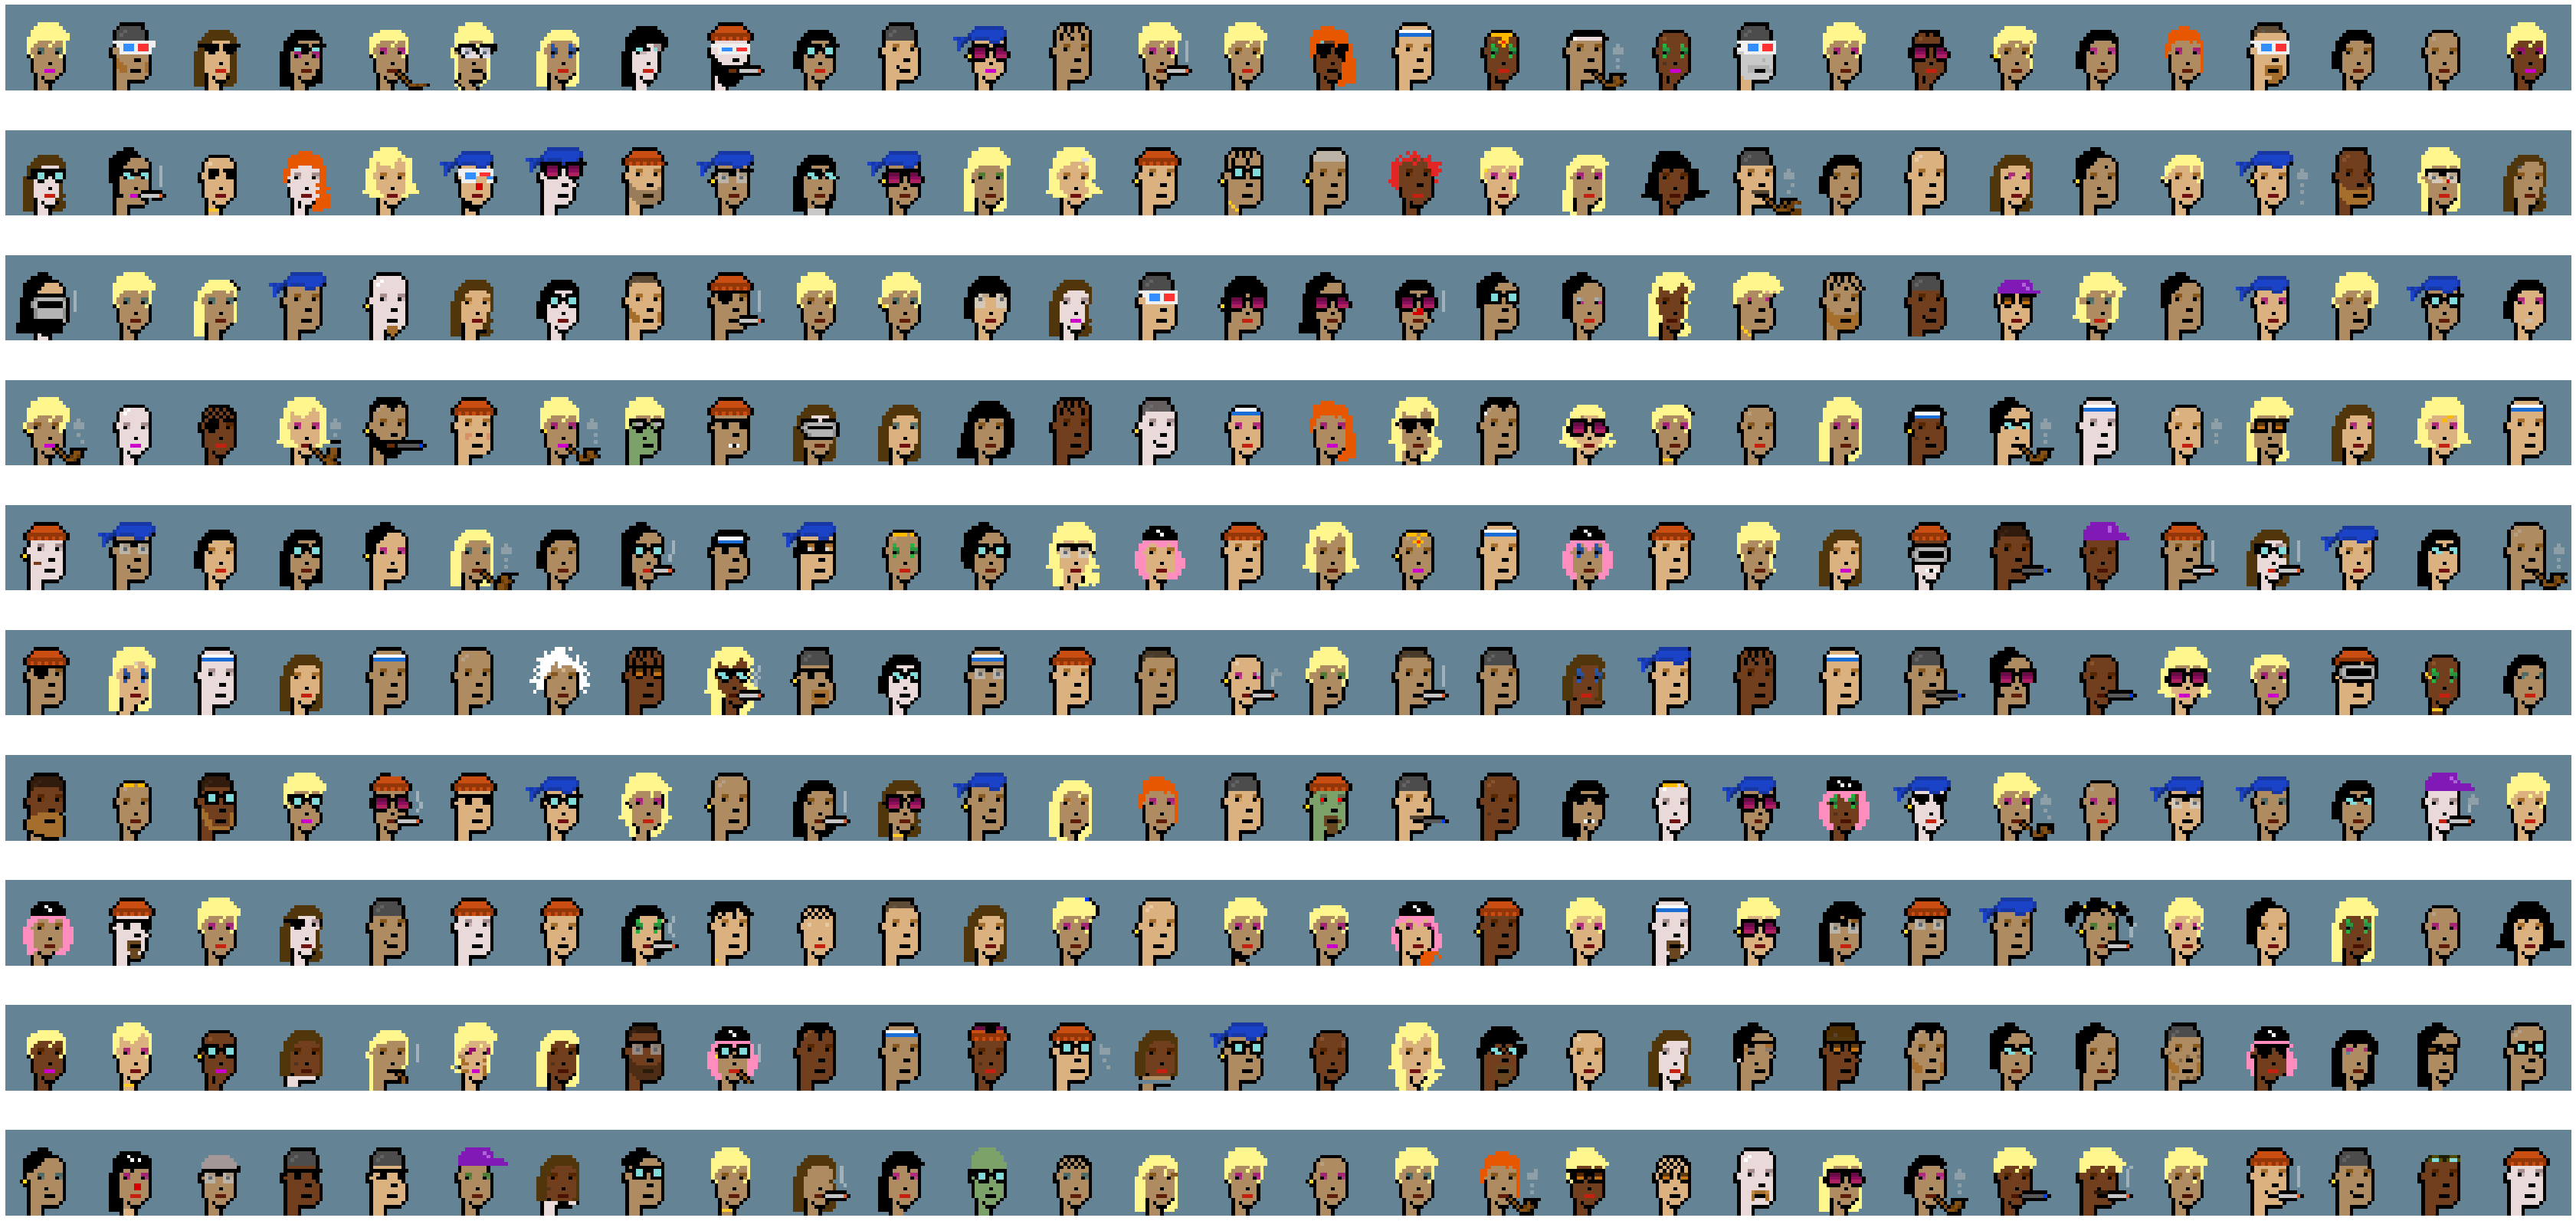

In [20]:
#define path
images = glob.glob("/content/drive/MyDrive/output_punks/*.png")

#define number of rows and cols
no_plots = 10*30

plt.rcParams['figure.figsize'] = (60, 30)
plt.subplots_adjust(wspace=0, hspace=0)

print("New CryptoPunks GPT-2")
for idx,image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    plt.subplot(10, 30, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB)) #covert color space
plt.show()

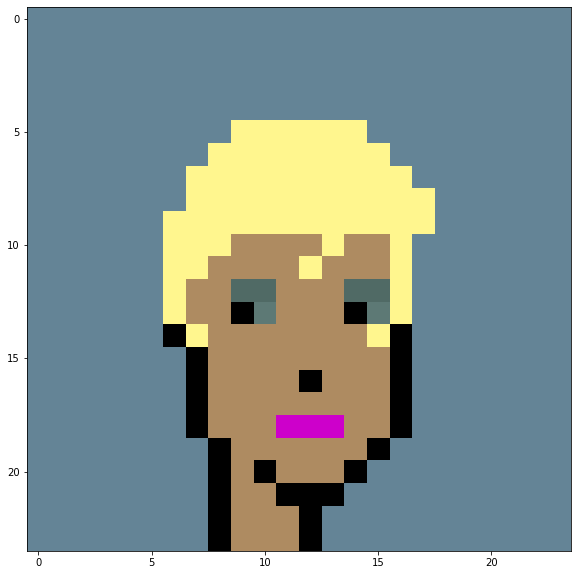

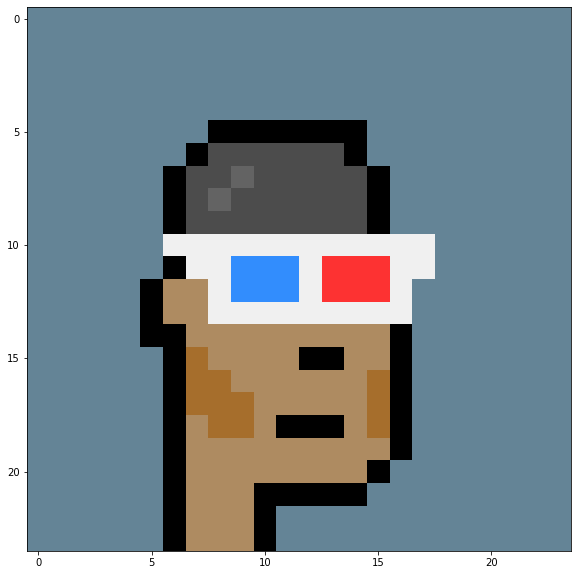

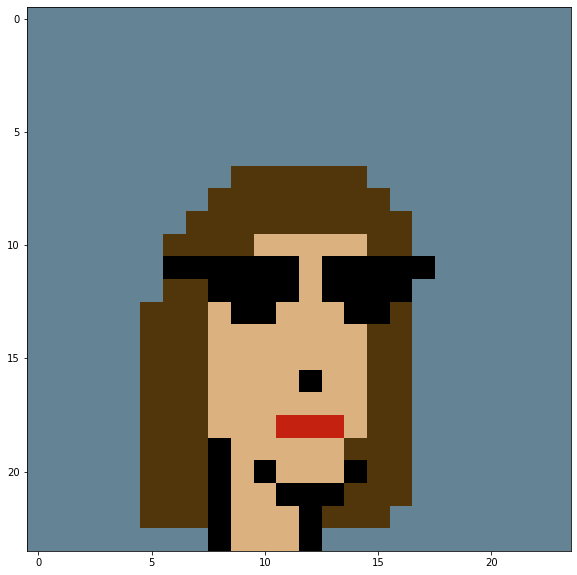

In [21]:
punks = [img for img in glob.glob("/content/drive/MyDrive/output_punks/*.png")]

for punk in punks[0:3]:
    plt.figure(figsize=(10, 10))
    img = plt.imread(punk)
    plt.imshow(img)
    plt.show()